In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
epochs = 200
batch_size = 64
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 3
seed = random.randint(1, 1000)
target_names=['Caterpillar','Diabrotica speciosa','Healthy']

data_dir = "../input/soybean-disease-dataset/train/"
data_dir1 = "../input/soybean-disease-dataset/test/"

In [3]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)
val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
)

Found 4618 images belonging to 3 classes.
Found 1153 images belonging to 3 classes.
Found 639 images belonging to 3 classes.


../input/soybean-disease-dataset/train/Diabrotica speciosa/diabroticaspeciosa (440).jpg


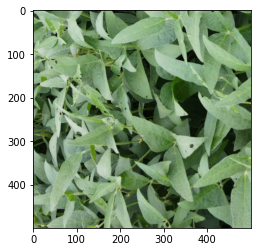

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('InceptionV3.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

2022-10-31 06:28:14.870427: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 06:28:14.870466: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 06:28:14.976029: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-10-31 06:28:15.059821: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 06:28:15.059982: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [6]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

2022-10-31 06:28:15.219258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:28:15.220263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:28:15.360466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:28:15.361379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:28:15.362213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [7]:
%%time

model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Beginning training
Epoch 1/200
Learning rate:  1e-04


2022-10-31 06:28:23.678763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-31 06:28:34.258732: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/73 [..............................] - ETA: 28:14 - loss: 1.3008 - accuracy: 0.3594

2022-10-31 06:28:47.255916: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 06:28:47.255985: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/73 [..............................] - ETA: 1:35 - loss: 1.1956 - accuracy: 0.3984 

2022-10-31 06:28:48.608877: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 06:28:48.612186: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-31 06:28:48.833224: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2156 callback api events and 2153 activity events. 
2022-10-31 06:28:48.919522: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 06:28:49.024477: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs-10312022062814/train/plugins/profile/2022_10_31_06_28_48

2022-10-31 06:28:49.083660: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs-10312022062814/train/plugins/profile/2022_10_31_06_28_48/33faedcd6451.trace.json.gz
2022-10-31 06:28:49.221018: I tensorflow/core/profiler/rpc/client/save_profile.cc:136]

73/73 [==============================] - 167s 2s/step - loss: 0.6463 - accuracy: 0.7741 - val_loss: 1.1043 - val_accuracy: 0.5768
End of epoch 0. Learning rate: 1e-04

Epoch 00001: val_accuracy improved from -inf to 0.57676, saving model to InceptionV3.h5
Epoch 2/200
Learning rate:  1e-04
73/73 [==============================] - 124s 2s/step - loss: 0.3591 - accuracy: 0.8792 - val_loss: 0.7977 - val_accuracy: 0.7008
End of epoch 1. Learning rate: 1e-04

Epoch 00002: val_accuracy improved from 0.57676 to 0.70078, saving model to InceptionV3.h5
Epoch 3/200
Learning rate:  1e-04
73/73 [==============================] - 125s 2s/step - loss: 0.2184 - accuracy: 0.9262 - val_loss: 0.8181 - val_accuracy: 0.7728
End of epoch 2. Learning rate: 1e-04

Epoch 00003: val_accuracy improved from 0.70078 to 0.77277, saving model to InceptionV3.h5
Epoch 4/200
Learning rate:  1e-04
73/73 [==============================] - 123s 2s/step - loss: 0.1383 - accuracy: 0.9500 - val_loss: 0.8403 - val_accuracy: 0

In [8]:
history = pd.DataFrame(model_history.history)
history.to_csv('InceptionV3.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,0.646286,0.774145,1.104269,0.576756,1.000000e-04
1,0.359053,0.879168,0.797737,0.700781,1.000000e-04
2,0.218398,0.926158,0.818142,0.772767,1.000000e-04
3,0.138273,0.949978,0.840318,0.808326,1.000000e-04
4,0.117092,0.958424,1.112952,0.748482,1.000000e-04
5,0.113864,0.963837,1.151126,0.760624,1.000000e-04
6,0.089867,0.968818,1.461061,0.773634,1.000000e-04
7,0.078846,0.973798,1.371169,0.796184,1.000000e-04
8,0.124061,0.961672,1.572498,0.794449,1.000000e-04
9,0.053932,0.983110,1.072343,0.832611,3.162277e-05


<h2>Plotting<h2>

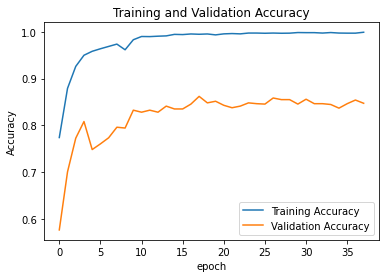

In [9]:
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

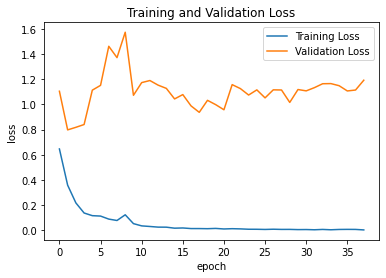

In [10]:
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

<h2>Model Evaluation<h2>

In [11]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
                     precision    recall  f1-score   support

        Caterpillar       0.94      0.94      0.94       330
Diabrotica speciosa       0.93      0.92      0.92       220
            Healthy       0.91      0.90      0.90        89

           accuracy                           0.93       639
          macro avg       0.92      0.92      0.92       639
       weighted avg       0.93      0.93      0.93       639



In [12]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.OrRd):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Normalized confusion matrix


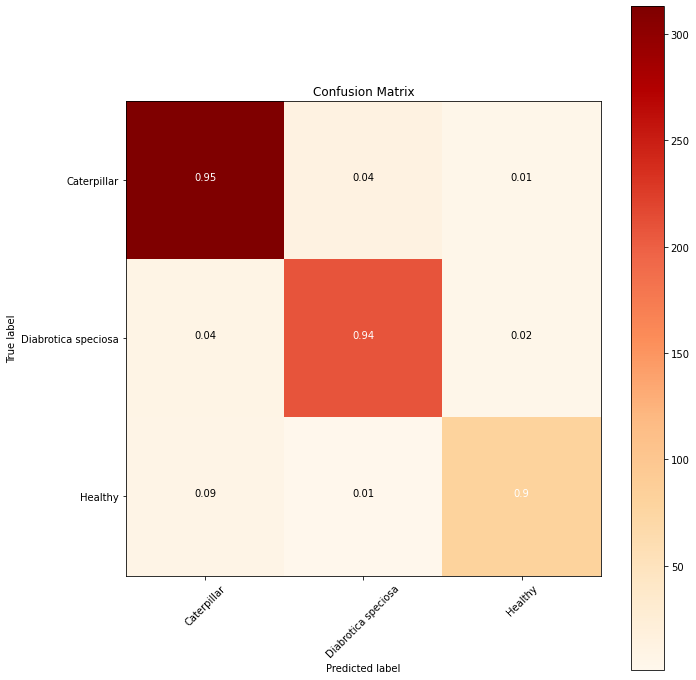

In [13]:
#Confution Matrix 
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Categories =target_names
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, Categories, title='Confusion Matrix')

In [14]:
model.evaluate(test_generator , verbose = 0)

[0.3702890872955322, 0.9358372688293457]

1


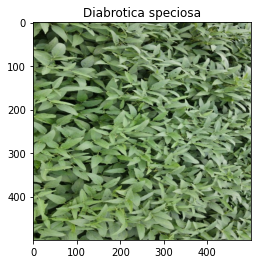

In [15]:
#Test the model
model = load_model('./InceptionV3.h5')

test_image='../input/soybean-disease-dataset/test/Diabrotica speciosa/diabroticaspeciosa (1010).jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(targetx, targety))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)

result=model.predict(test_image)
print(np.argmax(result))
Categories =target_names
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()

Image No: 0
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (221).jpg
0


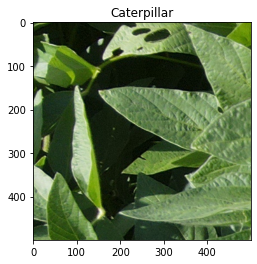

Image No: 1
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (1133).jpg
2


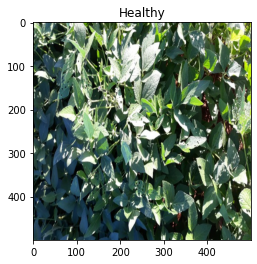

Image No: 2
../input/soybean-disease-dataset/test/Diabrotica speciosa/diabroticaspeciosa (846).jpg
1


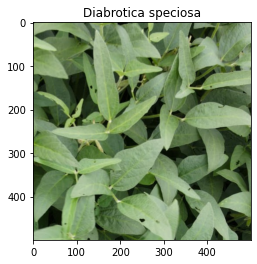

Image No: 3
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (1070).jpg
0


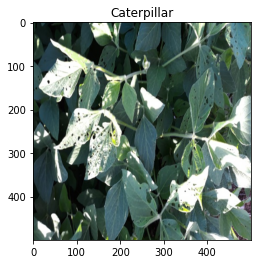

Image No: 4
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (68).jpg
0


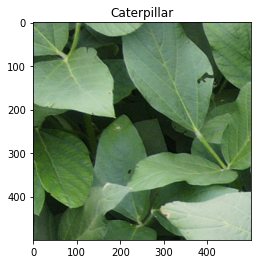

Image No: 5
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (3072).jpg
0


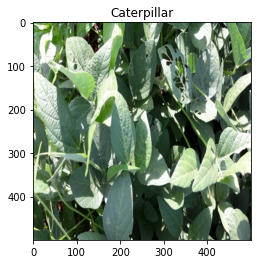

Image No: 6
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (440).jpg
0


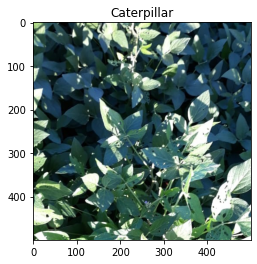

Image No: 7
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (68).jpg
0


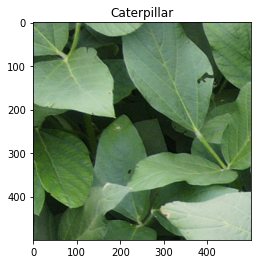

Image No: 8
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (1612).jpg
0


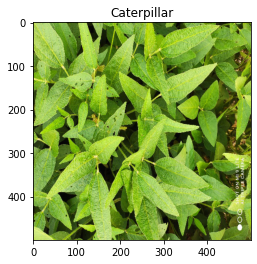

Image No: 9
../input/soybean-disease-dataset/test/Caterpillar/caterpillar (837).jpg
0


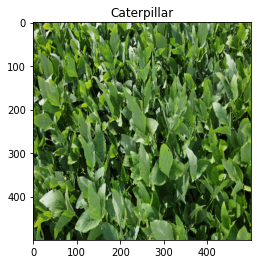

In [17]:
#Test the model
model = load_model('./InceptionV3.h5')

for i in range (0,10):
    print(f"Image No: {i}")
    
    test_image=test_generator.filepaths[np.random.random_integers(low=0, high=test_generator.samples)]
    print(test_image)
    image_result=Image.open(test_image)


    from tensorflow.keras.preprocessing import image
    test_image=image.load_img(test_image,target_size=(targetx, targety))
    test_image=image.img_to_array(test_image)
    test_image=test_image/255
    test_image=np.expand_dims(test_image,axis=0)

    result=model.predict(test_image)
    print(np.argmax(result))
    Categories =target_names
    image_result=plt.imshow(image_result)
    plt.title(Categories[np.argmax(result)])
    plt.show()